In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
np.random.seed(123)

In [4]:
# Function for reparameterization trick to make model differentiable
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

def sampling(args):
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
    
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

Using TensorFlow backend.


### Data Analysis and Importing

In [5]:
# Load in RNAseq data
import pickle

trainingPickle = 'train_data.pkl'
with open(trainingPickle, 'rb') as inTDat:
    trainingDat = pickle.load(inTDat).T
    
testingPickle = 'test_data.pkl'
with open(testingPickle, 'rb') as inTDat:
    testDat = pickle.load(inTDat).T
    
trainingPickle = 'train_labels.pkl'
with open(trainingPickle, 'rb') as inTDat:
    trainingLabel = pickle.load(inTDat).T
    
testingPickle = 'test_labels.pkl'
with open(testingPickle, 'rb') as inTDat:
    testLabel = pickle.load(inTDat).T

In [6]:
# Normalize data
trainingDat = np.log(trainingDat + 1)

# Visualize a single column
trainingDat.head(1)

,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
TCGA-OR-A5LN-01A-11R-A29S-07,0.0,1.197582,1.197582,4.641218,7.453478,0.0,4.797699,0.0,0.0,0.0,...,2.699534,5.348291,6.724089,0.0,6.392808,7.491594,6.735141,6.090093,5.903502,0.0


In [10]:
# Trim data with zero variances (assuming logarithm present)
eps = 1e-5
geneVars = trainingDat.var(axis=0).sort_values(ascending=False)
geneVars = geneVars.loc[geneVars > eps]

### Hyperparameter Tuning and Data Decimation

In [11]:
# Hyperparameters
latent_dim = 100        # reduction intensity

# data parameters
batch_size = 50
epochs = 1000
learning_rate = 0.0005

# Gaussian parameters
epsilon_std = 1.0
kappa = 1

# number of input genes to use
GENE_CAP = 5000

In [12]:
# Apply minmax normalization (normalize cols to 1)
# Check Tybalt for reasons...
trainingDat=(trainingDat-trainingDat.min())/(trainingDat.max()-trainingDat.min())

In [13]:
# Chop off data to first GENE_CAP genes
topVarGenes = geneVars.head(GENE_CAP).to_frame().T.columns.tolist()
smallTrainingDat = trainingDat[topVarGenes]
smallTrainingDat.shape

# used for the network later on
original_dim = smallTrainingDat.shape[1]
beta = K.variable(0)

Instructions for updating:
Colocations handled automatically by placer.


### Validation Set Setup

In [14]:
testDatSize = testDat.shape[0]

In [15]:
# Grab testNum/2 (10%) of the training data for validation
valDat = smallTrainingDat.sample(n=int(testDatSize/2),random_state=123)
smallTrainingDat = smallTrainingDat.drop(valDat.index)

In [16]:
valLabel = trainingLabel.sample(n=int(testDatSize/2),random_state=123)
trainingLabel = trainingLabel.drop(valLabel.index)

### Encoder / Decoder Setup (VAE)

In [17]:
# Input place holder for RNAseq data with specific input size
rnaInput = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rna input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaInput)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaInput)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
reconstructed = decoder_to_reconstruct(z)

In [18]:
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([rnaInput, reconstructed])
vae = Model(rnaInput, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5000)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          500100      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          500100      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100)          400         dense_1[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [19]:
%%time
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=6),
             WarmUpCallback(beta, kappa)]
hist = vae.fit(np.array(smallTrainingDat),
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(np.array(valDat), None),
               callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 7225 samples, validate on 1042 samples
Epoch 1/1000
7225/7225 [==============================] - 3s 404us/step - loss: 2992.9892 - val_loss: 2832.8069
Epoch 2/1000
7225/7225 [==============================] - 2s 214us/step - loss: 2780.3612 - val_loss: 2757.5173
Epoch 3/1000
7225/7225 [==============================] - 2s 222us/step - loss: 2739.2533 - val_loss: 2726.4512
Epoch 4/1000
7225/7225 [==============================] - 2s 209us/step - loss: 2716.3271 - val_loss: 2720.5490
Epoch 5/1000
7225/7225 [==============================] - 1s 205us/step - loss: 2703.1176 - val_loss: 2709.7796
Epoch 6/1000
7225/7225 [==============================] - 1s 205us/step - loss: 2691.7474 - val_loss: 2684.9492
Epoch 7/1000
7225/7225 [==============================] - 1s 201us/step - loss: 2684.8554 - val_loss: 2677.6759
Epoch 8/1000
7225/7225 [==============================] - 1s 204us/step - loss: 2678.0678 - val_loss: 2669.9407
Epoch 9/

7225/7225 [==============================] - 1s 205us/step - loss: 2601.7578 - val_loss: 2599.6276
Epoch 71/1000
7225/7225 [==============================] - 2s 215us/step - loss: 2601.6332 - val_loss: 2599.2577
Epoch 72/1000
7225/7225 [==============================] - 2s 213us/step - loss: 2601.5342 - val_loss: 2599.9319
Epoch 73/1000
7225/7225 [==============================] - 2s 225us/step - loss: 2600.6550 - val_loss: 2600.8317
Epoch 74/1000
7225/7225 [==============================] - 1s 206us/step - loss: 2601.0718 - val_loss: 2598.3796
Epoch 75/1000
7225/7225 [==============================] - 2s 209us/step - loss: 2600.3305 - val_loss: 2601.7120
Epoch 76/1000
7225/7225 [==============================] - 1s 204us/step - loss: 2600.4921 - val_loss: 2598.1820
Epoch 77/1000
7225/7225 [==============================] - 2s 213us/step - loss: 2600.1491 - val_loss: 2598.8548
Epoch 78/1000
7225/7225 [==============================] - 2s 215us/step - loss: 2599.8852 - val_loss: 2598.19

Text(0.5, 1.0, 'Plot of Losses vs Epochs')

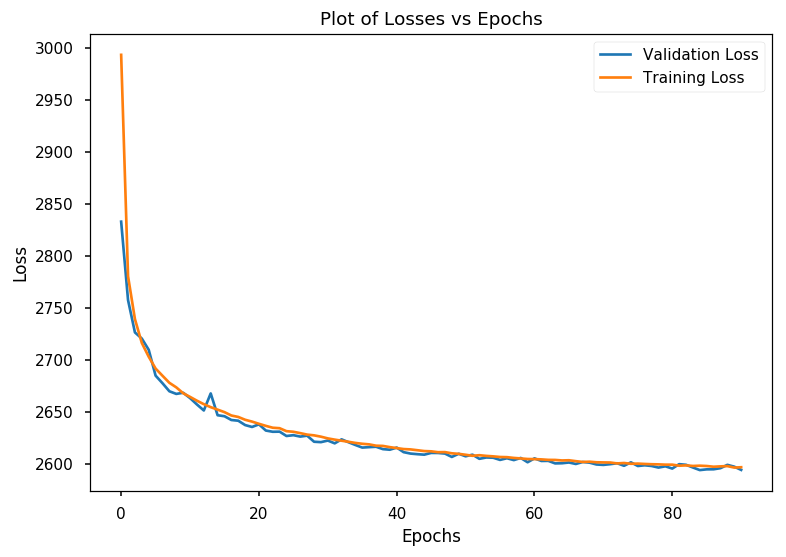

In [53]:
import matplotlib as mpl
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
plt.figure(dpi=110)
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.plot(hist.history['loss'], label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
legend = plt.legend()
plt.setp(legend.get_texts(), color='black')
plt.title("Plot of Losses vs Epochs")

In [20]:
encoder = Model(rnaInput, z_mean_encoded)
encoded_rnaseq_df = encoder.predict_on_batch(smallTrainingDat)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=smallTrainingDat.index)

In [54]:
# Encode validation data as well
encodedValDat = encoder.predict_on_batch(valDat)
encodedValDaf = pd.DataFrame(encodedValDat, index=valDat.index)

In [21]:
from sklearn.manifold import TSNE
n_sne = 7225
rndperm = np.random.permutation(smallTrainingDat.shape[0])
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(encoded_rnaseq_df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7225 samples in 0.039s...
[t-SNE] Computed neighbors for 7225 samples in 15.712s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7225
[t-SNE] Computed conditional probabilities for sample 2000 / 7225
[t-SNE] Computed conditional probabilities for sample 3000 / 7225
[t-SNE] Computed conditional probabilities for sample 4000 / 7225
[t-SNE] Computed conditional probabilities for sample 5000 / 7225
[t-SNE] Computed conditional probabilities for sample 6000 / 7225
[t-SNE] Computed conditional probabilities for sample 7000 / 7225
[t-SNE] Computed conditional probabilities for sample 7225 / 7225
[t-SNE] Mean sigma: 6.371271
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.266830
[t-SNE] KL divergence after 300 iterations: 1.919096


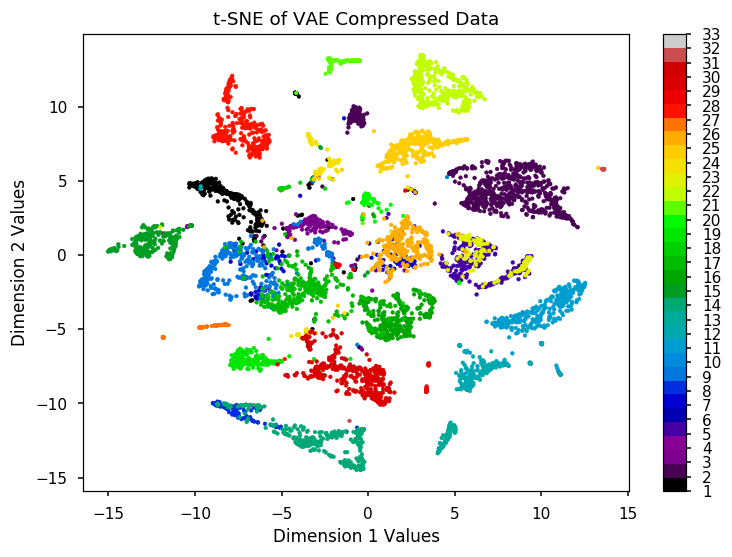

In [24]:
vis_x = tsne_results[:, 0]
vis_y = tsne_results[:, 1]

# import matplotlib as mpl
# mpl.rcParams['text.color'] = 'black'
# mpl.rcParams['axes.labelcolor'] = 'black'
# mpl.rcParams['xtick.color'] = 'black'
# mpl.rcParams['ytick.color'] = 'black'

fig = plt.figure(dpi=110)
ax = fig.add_subplot(111)
plt.scatter(vis_x, vis_y, c=trainingLabel.idxmax(axis=1), cmap=plt.cm.get_cmap("nipy_spectral", 33),s=6)
plt.colorbar(ticks=range(1,34))
plt.clim(1,33)
plt.title("t-SNE of VAE Compressed Data")
plt.xlabel("Dimension 1 Values")
plt.ylabel("Dimension 2 Values")

plt.show()

In [56]:
# Hyperparameters for MLP model
in_size = encoded_rnaseq_df.shape[1]
nh1 = 20; # hidden neurons in first hidden layer
o_class = 33; # number of classes to output to
mlp_lr = 0.0001

In [57]:
# Two Layer MLP with softmax activations
inputLayer = Input(shape=(in_size,))
hidden1 = Dense(nh1, activation='relu')(inputLayer)
softOutput = Dense(o_class, activation='softmax')(hidden1)
model = Model(inputs=inputLayer, outputs=softOutput)
adam = optimizers.Adam(lr=mlp_lr)

In [61]:
# Train model
from keras.callbacks import EarlyStopping
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
model.summary()

MLPhist = model.fit(encoded_rnaseq_df, trainingLabel,
                        validation_data=(np.array(encodedValDat), np.array(valLabel)),
                        epochs=1000,   # large value since auto stopping
                        batch_size=batch_size,
                        verbose=True,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_5 (Dense)              (None, 33)                693       
Total params: 2,713
Trainable params: 2,713
Non-trainable params: 0
_________________________________________________________________
Train on 7225 samples, validate on 1042 samples
Epoch 1/1000
7225/7225 [==============================] - 1s 118us/step - loss: 0.2103 - acc: 0.9320 - val_loss: 0.2410 - val_acc: 0.9328
Epoch 2/1000
7225/7225 [==============================] - 1s 71us/step - loss: 0.1935 - acc: 0.9367 - val_loss: 0.2386 - val_acc: 0.9328
Epoch 3/1000
7225/7225 [==============================] - 1s 72us/step - loss: 0.

Epoch 55/1000
7225/7225 [==============================] - 0s 66us/step - loss: 0.1152 - acc: 0.9585 - val_loss: 0.1953 - val_acc: 0.9376
Epoch 56/1000
7225/7225 [==============================] - 0s 66us/step - loss: 0.1145 - acc: 0.9583 - val_loss: 0.1936 - val_acc: 0.9386
Epoch 57/1000
7225/7225 [==============================] - 0s 65us/step - loss: 0.1143 - acc: 0.9578 - val_loss: 0.1931 - val_acc: 0.9376
Epoch 58/1000
7225/7225 [==============================] - 0s 65us/step - loss: 0.1135 - acc: 0.9588 - val_loss: 0.1944 - val_acc: 0.9376
Epoch 59/1000
7225/7225 [==============================] - 0s 65us/step - loss: 0.1125 - acc: 0.9592 - val_loss: 0.1933 - val_acc: 0.9376
Epoch 60/1000
7225/7225 [==============================] - 0s 68us/step - loss: 0.1118 - acc: 0.9600 - val_loss: 0.1932 - val_acc: 0.9395
Epoch 61/1000
7225/7225 [==============================] - 0s 66us/step - loss: 0.1115 - acc: 0.9593 - val_loss: 0.1952 - val_acc: 0.9376
Epoch 62/1000
7225/7225 [=========

In [63]:
# Set up test data similarly to training
testDat = np.log(testDat + 1)
testDat = (testDat-testDat.min())/(testDat.max()-testDat.min())
extractedTestDat = testDat[topVarGenes]
evalTestDat = encoder.predict_on_batch(extractedTestDat)

# Evaluate on testing dataset
testRes = model.evaluate(x=evalTestDat, y=testLabel)

2085/2085 [==============================] - 0s 38us/step


In [64]:
print(testRes)

[0.1788971825606107, 0.93621103117506]
